**First, let's open the dataset and examime the general information**

In [119]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm
from sklearn.dummy import DummyClassifier

In [100]:

df = pd.read_csv('/datasets/users_behavior.csv')
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


The dataset consists of five fields, there are no empty values. The data type is also correct.

Let's divide the data into samples, stratifying the classes.

In [102]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345, stratify=target)
print(f'Кол-во строк в target_train по классам: {np.bincount(target_train)}')
print(f'Кол-во строк в target_test по классам: {np.bincount(target_test)}')
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.25, random_state=12345, stratify=target_train)
print(f'Кол-во строк в target_train по классам: {np.bincount(target_train)}')
print(f'Кол-во строк в target_valid по классам: {np.bincount(target_test)}')


Кол-во строк в target_train по классам: [1783  788]
Кол-во строк в target_test по классам: [446 197]
Кол-во строк в target_train по классам: [1337  591]
Кол-во строк в target_valid по классам: [446 197]


In [104]:
print(df.shape[0])
print(features_train.shape[0] + features_test.shape[0] + features_valid.shape[0])
print(target_train.shape[0] + target_test.shape[0] + target_valid.shape[0])

3214
3214
3214


## Exploring the models

Model: Decision tree

In [105]:
best_model = None
best_accuracy = 0
max_depth = 1
for depth in range(1, 11):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    result = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, result)
    if accuracy > best_accuracy:
        best_model = model
        best_accuracy = accuracy
        max_depth = depth
print(f'max_depth = {max_depth} :', best_accuracy)
print("F1:", f1_score(target_valid, result))


max_depth = 5 : 0.8164852255054432
F1: 0.6355685131195334


The best value for the depth of the tree is 5. Let's draw a decision tree with depth = 3 to illustrate the mechanics of decision making by the model.

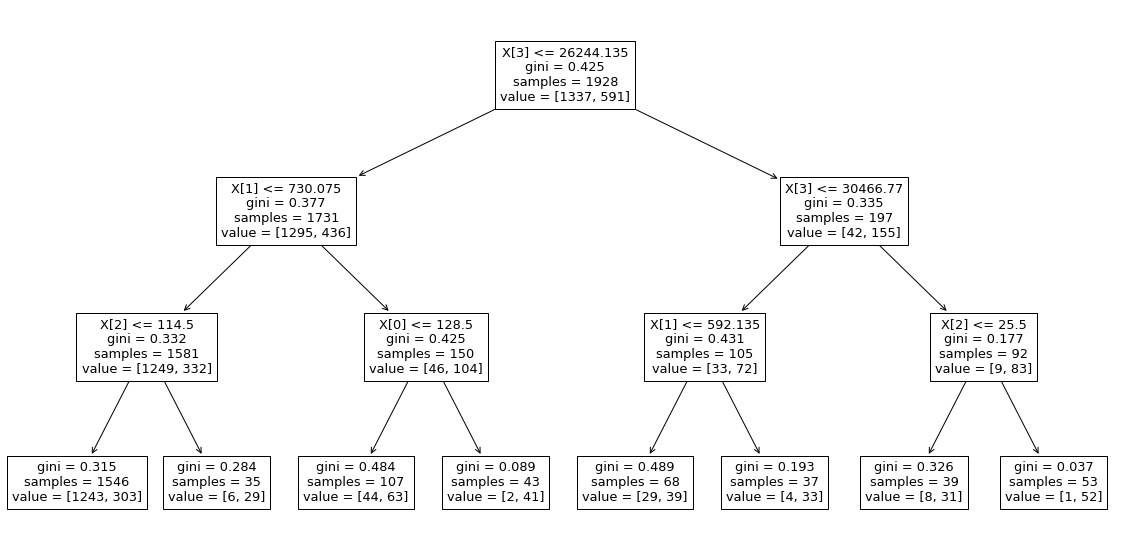

In [106]:
model_depth_3 = DecisionTreeClassifier(max_depth=3, random_state=12345)
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)
tree.plot_tree(model_depth_3.fit(features_train, target_train))
plt.show()

Model: Random forest

In [107]:
best_model_forest = None
best_accuracy_forest = 0
n_estimators = 1
for est in tqdm(range(1, 11)):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(features_train, target_train)
    #result = model.predict(features_valid)
    accuracy = model.score(features_valid, target_valid)
    if accuracy > best_accuracy_forest:
        best_model_forest = model
        best_accuracy_forest = accuracy
        n_estimators = est
print(f'n_estimators = {n_estimators} :', best_accuracy_forest)

100%|██████████| 10/10 [00:00<00:00, 32.62it/s]

n_estimators = 10 : 0.8133748055987559


Model: Logistic regression

In [108]:
model_regression = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_regression.fit(features_train, target_train)
model_regression.predict(features_valid)
accuracy_regression = model_regression.score(features_valid, target_valid)
print(accuracy_regression)

0.7558320373250389


## Let's check the model on a test sample

Now let's train the Decison tree model on training + validation samples and test it on the test.

In [110]:
features_train = pd.concat([features_train, features_valid])
target_train = pd.concat([target_train, target_valid])
print(features_train.shape[0], target_train.shape[0])

2571 2571


In [111]:
model = DecisionTreeClassifier(max_depth=5, random_state=12345)
model.fit(features_train, target_train)
result = model.predict(features_test)
accuracy = accuracy_score(target_test, result)
print(accuracy)
print("F1:", f1_score(target_test, result))


0.7838258164852255
F1: 0.5723076923076923


Accuracy on test sample is 0.78.

## Let't check the models for adequacy

Let's check the model for adequacy by comparing it with a constant one, where all predictions are equal to 0 - the most frequent value in the target. For a better understanding, I tried to do this in two ways, the results are similar.

In [114]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

In [116]:
predicted_test = pd.Series(0, index=target_test.index)
print(accuracy_score(target_test, predicted_test))

0.6936236391912908


In [118]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(features_train, target_train)
predicted_test = dummy_clf.predict(features_test)
print(dummy_clf.score(features_test, target_test))
print(accuracy_score(target_test, predicted_test)) 

0.6936236391912908
0.6936236391912908


Our model turned out to be more accurate than the constant one.

**Summary of work done:**

The work began with loading and examining the dataset, ensuring its integrity and structure. The dataset, comprising five fields, was devoid of any empty values, with correct data types assigned. Subsequently, the data was divided into training, validation, and testing samples, ensuring class stratification.

The exploration of models commenced with a Decision Tree Classifier, where the optimal depth was determined through iterative evaluation. A depth of 5 was identified as optimal, exemplified by visualizing a decision tree of depth 3.

Proceeding to the Random Forest model, its performance was gauged by varying the number of estimators, ultimately identifying the optimal number as 10.

The Logistic Regression model was then assessed, yielding an accuracy score.

Subsequently, the Decision Tree model was trained on the combined training and validation samples and tested on the test sample, yielding an accuracy of 0.78.

Finally, the Decision tree model was evaluated for adequacy by comparing it against a constant model where all predictions were set to the most frequent class. Comparison indicated that the constructed model outperformed the constant model, thus affirming its adequacy.